In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Conv1D, MaxPooling1D, LSTM
import seaborn as sns
import tensorflow_addons as tfa


In [7]:
data = pd.read_csv("rul_hrs.csv", index_col='timestamp')

In [8]:
data=data.drop("Unnamed: 0",axis=1)
data.index = pd.to_datetime(data.index)

In [9]:
data.shape

(166441, 51)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166441 entries, 2018-04-01 00:00:00 to 2018-07-25 14:00:00
Data columns (total 51 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sensor_00  166441 non-null  float64
 1   sensor_01  166441 non-null  float64
 2   sensor_02  166441 non-null  float64
 3   sensor_03  166441 non-null  float64
 4   sensor_04  166441 non-null  float64
 5   sensor_05  166441 non-null  float64
 6   sensor_06  166441 non-null  float64
 7   sensor_07  166441 non-null  float64
 8   sensor_08  166441 non-null  float64
 9   sensor_09  166441 non-null  float64
 10  sensor_10  166441 non-null  float64
 11  sensor_11  166441 non-null  float64
 12  sensor_12  166441 non-null  float64
 13  sensor_13  166441 non-null  float64
 14  sensor_14  166441 non-null  float64
 15  sensor_16  166441 non-null  float64
 16  sensor_17  166441 non-null  float64
 17  sensor_18  166441 non-null  float64
 18  sensor_19  166441 non-null  fl

In [11]:
idx=data[data["rul"]==0].index.tolist()

In [12]:
val=[0,0,0,0,0,0,0]

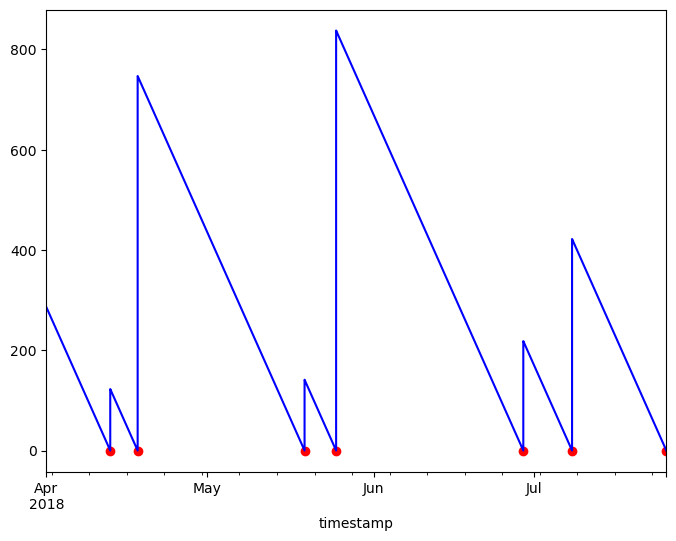

In [13]:
idx=data[data["rul"]==0].index.tolist()
val = [0] * len(idx)
plt.figure(figsize=(8,6))
data["rul"].plot(color="blue")
plt.scatter(idx,val,color="red")

<Axes: xlabel='timestamp'>

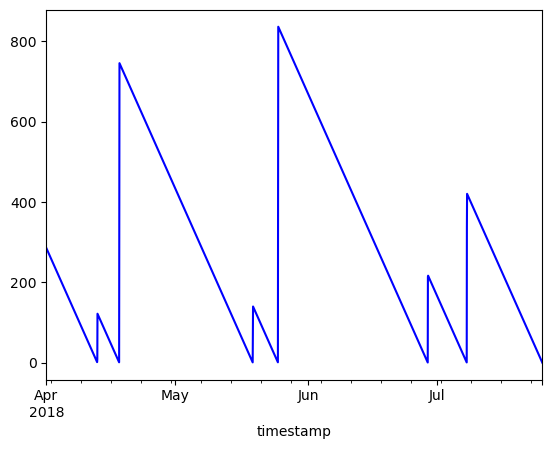

In [14]:
dat = data.groupby(data.index.to_period('H')).mean()
dat["rul"].plot(color="blue")

In [15]:
dat["extrema"]=0
for i in range(1,dat.shape[0]-1):
    if ((dat.iloc[i-1,50]-dat.iloc[i,50])*(dat.iloc[i,50]-dat.iloc[i+1,50])<=0.6):
        dat.iloc[i,51]=1
dat[dat["extrema"]==1].shape

(13, 52)

In [16]:
index=dat[dat["extrema"]==1].index
index

PeriodIndex(['2018-04-12 20:00', '2018-04-12 22:00', '2018-04-17 23:00',
             '2018-04-18 01:00', '2018-05-19 02:00', '2018-05-19 04:00',
             '2018-05-24 23:00', '2018-05-25 01:00', '2018-06-28 21:00',
             '2018-06-28 23:00', '2018-07-07 23:00', '2018-07-08 01:00',
             '2018-07-25 13:00'],
            dtype='period[H]', name='timestamp')

In [17]:
dat=dat.drop("extrema",axis=1)

In [18]:
List_index=[index[0]]
i=0
for date in index[1:len(index)]:
    if abs((int(date.day)-int(List_index[i].day)))>1:
        List_index.append(date)
        i=i+1
       

In [19]:
List_index

[Period('2018-04-12 20:00', 'H'),
 Period('2018-04-17 23:00', 'H'),
 Period('2018-05-19 02:00', 'H'),
 Period('2018-05-24 23:00', 'H'),
 Period('2018-06-28 21:00', 'H'),
 Period('2018-07-07 23:00', 'H'),
 Period('2018-07-25 13:00', 'H')]

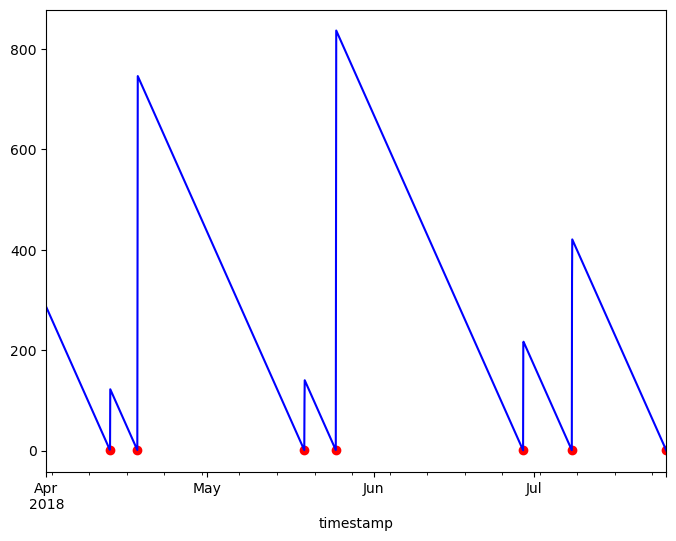

In [20]:
plt.figure(figsize=(8,6))
dat["rul"].plot(color="blue")
plt.scatter(List_index,dat.loc[List_index,"rul"],color="red")
plt.savefig("RUL.png", dpi=300, bbox_inches='tight')

In [21]:
List_index=[dat.index[0]]+List_index
List_index

[Period('2018-04-01 00:00', 'H'),
 Period('2018-04-12 20:00', 'H'),
 Period('2018-04-17 23:00', 'H'),
 Period('2018-05-19 02:00', 'H'),
 Period('2018-05-24 23:00', 'H'),
 Period('2018-06-28 21:00', 'H'),
 Period('2018-07-07 23:00', 'H'),
 Period('2018-07-25 13:00', 'H')]

In [22]:
numerical_features=list(dat.columns)

In [23]:
dat['monat'] = dat.index.month  # Mois
dat['tag'] = dat.index.day  # Jour
dat['uhr']= dat.index.hour

In [24]:
categorical_features=['monat','tag','uhr']

In [25]:
numerical_pipeline=make_pipeline(StandardScaler())
categorical_pipeline=make_pipeline(OneHotEncoder())
preprocessor= make_column_transformer((numerical_pipeline,numerical_features),(categorical_pipeline,categorical_features))#
dat_transformed = preprocessor.fit_transform(dat)
col_names = numerical_features + list(preprocessor.named_transformers_['pipeline-2'].named_steps['onehotencoder'].get_feature_names_out(categorical_features))
dat_transformed  = pd.DataFrame(dat_transformed, columns=col_names, index=dat.index)

In [26]:
dat=dat_transformed

In [27]:
data_list=[]
for i in range(len(List_index)-1):
    data_list.append(dat.loc[List_index[i]:List_index[i+1],:].iloc[3:-3,:])

In [28]:
dat.loc[List_index[6]:List_index[7],:].iloc[2:,:]

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,uhr_14,uhr_15,uhr_16,uhr_17,uhr_18,uhr_19,uhr_20,uhr_21,uhr_22,uhr_23
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-07-08 01:00,-3.507300,-0.865547,0.342428,0.455843,-2.618618,-1.996450,0.153706,-0.478472,-0.462420,-0.554152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-08 02:00,-3.181785,-0.937115,0.270906,0.341858,-1.349087,-1.243184,-0.417554,-0.839013,-0.845171,-0.928260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-08 03:00,-1.951807,-0.984898,0.228238,0.307044,-0.303384,-0.600896,-0.708072,-0.835651,-0.850196,-0.923667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-08 04:00,-0.157712,-0.957078,0.239779,0.367687,0.272792,0.166821,-0.006000,-0.472512,-0.462532,-0.681737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-08 05:00,0.114892,-0.898889,0.250971,0.531365,0.333207,-0.014568,0.850864,0.226564,0.309448,0.148510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-25 09:00,0.317602,-0.620261,0.445776,0.298902,0.274254,-0.032136,0.557160,0.227685,0.311122,0.189687,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-25 10:00,0.318343,-0.564832,0.321968,0.432260,0.205615,-0.185049,0.620027,0.229264,0.307158,0.190012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-25 11:00,0.318751,-0.483283,0.375653,0.572074,0.208360,-0.161602,0.644439,0.227685,0.308889,0.198712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
sequence_length = 48
forecast_length = 24
sequence_step = 1

In [30]:
x=[]
y=[]
for d in data_list:
    for i in range(0, d.shape[0] - sequence_length - forecast_length, sequence_step):
        x.append(d.iloc[i:i+sequence_length, :])
        y.append(d.iloc[i+sequence_length: i+sequence_length +
             forecast_length, 50])

In [31]:
x= np.array(x, dtype=np.float32)
y= np.array(y, dtype=np.float32)

In [32]:
y.shape

(2234, 24)

In [33]:
x_train, x_val, y_train, y_val= train_test_split(
x, y, test_size=0.2,  shuffle=False)

In [34]:
x_val, x_test, y_val, y_test = train_test_split(
x_val, y_val, test_size=0.5, shuffle=False)

In [35]:
model = keras.models.Sequential()
model.add(keras.layers.Input((x_train.shape[1:])))
#model.add(Conv1D(64, 3, activation='relu', input_shape=(x_train.shape[1:])))
#model.add(MaxPooling1D(2))
model.add(keras.layers.LSTM(100,
                            recurrent_dropout=0.0,
                            
                            dropout=0,
                            return_sequences=True,
                            kernel_regularizer=regularizers.l2(0.1)))
model.add(keras.layers.LSTM(100,
                            recurrent_dropout=0,
                            
                            dropout=0,
                            return_sequences=False,
                            kernel_regularizer=regularizers.l2(0.1)))
model.add(keras.layers.Dense(10,
                             activation='relu'))
model.add(keras.layers.Dropout(0))
model.add(keras.layers.Dense(forecast_length,
                             activation='linear'))



In [36]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # 0.001
model.compile(loss='mse', optimizer=optimizer,  # mse
              metrics=[tfa.metrics.RSquare()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 100)           84400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 24)                264       
                                                                 
Total params: 166074 (648.73 KB)
Trainable params: 166074 (648.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lr_reduction = keras.callbacks.ReduceLROnPlateau(patience=100,
                                                 monitor='loss',
                                                 min_lr=1e-6,
                                                 cool_down=25)

early_stopping = keras.callbacks.EarlyStopping(patience=300,
                                              monitor='val_loss',
                                              restore_best_weights=True)

model.fit(x_train, y_train, epochs=500,
                    batch_size=20, validation_data=(x_val, y_val),
                    callbacks=[lr_reduction, early_stopping])


Epoch 1/500
90/90 [==============================] - 21s 111ms/step - loss: 11.9554 - r_square: 0.3049 - val_loss: 1.5871 - val_r_square: 0.5824 - lr: 0.0010
Epoch 2/500
90/90 [==============================] - 9s 101ms/step - loss: 0.5697 - r_square: 0.8214 - val_loss: 0.0707 - val_r_square: 0.9161 - lr: 0.0010
Epoch 3/500
90/90 [==============================] - 7s 81ms/step - loss: 0.0730 - r_square: 0.9522 - val_loss: 0.1541 - val_r_square: 0.5542 - lr: 0.0010
Epoch 4/500
90/90 [==============================] - 8s 84ms/step - loss: 0.0523 - r_square: 0.9712 - val_loss: 0.0383 - val_r_square: 0.9217 - lr: 0.0010
Epoch 5/500
90/90 [==============================] - 7s 78ms/step - loss: 0.0412 - r_square: 0.9740 - val_loss: 0.5050 - val_r_square: -0.6619 - lr: 0.0010
Epoch 6/500
90/90 [==============================] - 8s 92ms/step - loss: 0.0281 - r_square: 0.9901 - val_loss: 0.0704 - val_r_square: 0.7907 - lr: 0.0010
Epoch 7/500
90/90 [==============================] - 7s 82ms/step

In [ ]:
model.save('wasser.keras')

In [ ]:
# Wir plotten die Lernkurven
history = model.history.history
plt.plot(history['loss'], label='Train data')
plt.plot(history['val_loss'], label='Validation data')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("loss_curve.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(history['r_square'], label='Train data')
plt.plot(history['val_r_square'], label='Validation data')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('r_square')
plt.savefig("r_square__curve.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
test_loss, test_r2 = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test R² Score: {test_r2:.4f}")  # Si R² Score est une métrique suivie


In [ ]:
y_pred_test=model.predict(x_test)

In [ ]:
test_loss, test_r2 = model.evaluate(x_val, y_val)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test R² Score: {test_r2:.4f}")  # Si R² Score est une métrique suivie


In [ ]:
test_loss, test_r2 = model.evaluate(x_train, y_train)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test R² Score: {test_r2:.4f}")  # Si R² Score est une métrique suivie


In [ ]:

# Obtenir les valeurs min et max
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())

# Affichage du scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, label='Prédictions', alpha=0.5)

# Tracer une ligne idéale
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Idéal')

plt.xlabel('y_test')
plt.ylabel('y_pred_test')
plt.legend()
plt.savefig("ypred_test_ytrue.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
y_pred_test=model.predict(x_test)